In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import scipy

from matplotlib import pyplot as plt
import matplotlib.ticker as plt_ticker

### Utility Functions

In [2]:
def get_drift_volatility(symbol, period='45d'):
    
    # Get NSE Historic Data
    ticker = yf.Ticker(symbol)
    df = ticker.history(period=period)['Close'].reset_index()

    # Calculate Daily Returns
    df['Prev Close'] = df['Close'].shift(1)
    df['Daily Rt'] = np.log(df['Close'] / df['Prev Close'])

    # Calculate Daily and Annualized Drift
    daily_drift = df['Daily Rt'].mean()
    annual_drift = daily_drift * 252

    # Calculate Daily and Annualized Volatility
    daily_volatility = df['Daily Rt'].std()
    annual_volatility = daily_volatility * np.sqrt(252)

    # Drift Mean
    drift_mean = daily_drift - (0.5 * (daily_volatility ** 2))

    # Last Trading Price and 3 week earlier prices
    ltd = []
    ltp = []
    for i in range(4):
        ltd.append(df['Date'].iloc[-1-(5*i)].strftime('%Y%m%d')) 
        ltp.append(df['Close'].iloc[-1-(5*i)])

    return daily_drift, annual_drift, daily_volatility, annual_volatility, drift_mean, dict(zip(ltd, ltp))

In [3]:
def gbm(initial_shock, drift_mean, daily_volatility, t=5):

    price = []

    for i in range(t):
        z = scipy.stats.norm.ppf(np.random.rand())
        log_return = drift_mean + daily_volatility * z
        p = initial_shock * np.exp(log_return)
        initial_shock = p
        price.append(p)

    return price

In [4]:
def sim_k_runs(cur_st, sp_cols, k=1000, last_run=1):

    # display(cur_st)

    # GBM simulations
    simulation = []
    for i in range(k):
        ltp = cur_st[sp_cols[last_run]].values[0]
        dm = cur_st['Drift Mean'].values[0]
        dv = cur_st['Daily Volatility'].values[0]
        
        sim_i = gbm(ltp, dm, dv)
        simulation.append(sim_i)

    # Capture stats
    sim_df = pd.DataFrame(simulation)

    daily_stats = []

    for i in sim_df.columns:
        day_stats = {
            'dm'.format(i+1): sim_df[i].mean(),
            'dm+std'.format(i+1): sim_df[i].mean() + sim_df[i].std(),
            'dm-std'.format(i+1): sim_df[i].mean() - sim_df[i].std()
        }

        daily_stats.append(day_stats)
    
        stat_df = pd.DataFrame(daily_stats)
    
    display(stat_df)

    # Ploting figure
    fig, ax = plt.subplots(1,1);

    stat_df['dm'].plot(label='mean', c='blue');
    stat_df['dm+std'].plot(label='+std', c='blue', alpha=0.5);
    stat_df['dm-std'].plot(label='-std', c='blue', alpha=0.5) ;  

    plt.plot(sim_df.sample(100).T, label='__', alpha=0.2);

    if last_run > 0:
        xx = np.vstack([0, 4]);
        yy = np.vstack([cur_st[sp_cols[last_run]].values[0] ,cur_st[sp_cols[last_run-1]].values[0]]);
        plt.plot(xx,yy, '-ok', mfc='C1', mec='C1', label='actual sp');

    plt.legend();
    plt.title(cur_st['Symbol'].values[0]);

    ax.xaxis.set_major_locator(plt_ticker.MultipleLocator(1));
    plt.xlabel('Time interval in days');
    plt.ylabel('Closing Price of the day');

    plt.figtext(0.5, 1, 
        """Start Date: {}, Predicted for 5 trading days forward
        Actuals --> start price={:.1f}, end price={}
        Predicted Mean Value with confidence interval --> {:.1f} <= {:.1f} <= {:.1f}
        
        """.format(
            sp_cols[last_run].replace('sp_', ''),
            cur_st[sp_cols[last_run]].values[0],
            round(cur_st[sp_cols[last_run-1]].values[0], 1) if last_run > 0 else 'Unknown Future Price',
            stat_df['dm-std'].iloc[-1], 
            stat_df['dm'].iloc[-1],
            stat_df['dm+std'].iloc[-1]
        ), 
        ha="center", 
        fontsize=8, 
        bbox={"facecolor":"orange", "alpha":0.5, "pad":2}
    );
    plt.tight_layout();

    plt.fill_between(range(5), stat_df['dm+std'], stat_df['dm-std'], color='blue', alpha=0.4);
    plt.show();


### Experiment

In [5]:
# URL to get the list of NSE stocks
nse_tickers_url = '../data/static/ind_nifty50list.csv'

# Read the data from the URL
tickers_df = pd.read_csv(nse_tickers_url)

# Extract the Symbol column
tickers = tickers_df['Symbol'].tolist()

# Print all NSE tickers
vol_df = []
for ticker in tickers:
   dd, ad, dv, av, dm, ltdp = get_drift_volatility(ticker+'.NS')

   tmp = {
      'Symbol': ticker,
      'Daily Drift': dd,
      'Annual Drift': ad,
      'Daily Volatility': dv,
      'Annual Volatility': av,
      'Drift Mean': dm
   }

   for d, p in ltdp.items():
      tmp.update({
         'sp_' + d: p
      })

   vol_df.append(tmp)

vol_df = pd.DataFrame(vol_df)

In [6]:
vol_df

,Symbol,Daily Drift,Annual Drift,Daily Volatility,Annual Volatility,Drift Mean,sp_20240524,sp_20240516,sp_20240509,sp_20240502
0,ADANIENT,0.001764,0.444456,0.020149,0.319861,0.001561,3384.949951,3041.649902,2766.649902,3039.600098
1,ADANIPORTS,0.002243,0.565313,0.016450,0.261137,0.002108,1416.099976,1345.050049,1244.550049,1338.800049
2,APOLLOHOSP,-0.000263,-0.066287,0.016408,0.260472,-0.000398,5914.350098,5931.700195,5806.399902,5958.549805
3,ASIANPAINT,0.000057,0.014362,0.014559,0.231118,-0.000049,2874.750000,2814.050049,2710.100098,2975.399902
4,AXISBANK,0.002615,0.658986,0.014619,0.232066,0.002508,1174.000000,1139.300049,1115.650024,1149.849976
5,BAJAJ-AUTO,0.001571,0.395795,0.014838,0.235550,0.001461,8948.200195,8871.849609,8846.849609,9110.650391
6,BAJFINANCE,0.001098,0.276782,0.017810,0.282727,0.000940,6836.899902,6747.149902,6605.149902,6882.700195
7,BAJAJFINSV,0.000433,0.109201,0.012988,0.206186,0.000349,1601.699951,1596.000000,1564.599976,1615.449951
8,BPCL,0.002481,0.625262,0.021081,0.334655,0.002259,654.099976,618.750000,592.150024,634.650024
9,BHARTIARTL,0.002940,0.740955,0.013539,0.214927,0.002849,1388.500000,1345.099976,1275.449951,1304.050049


In [7]:
sp_cols = [col for col in vol_df.columns if col.startswith('sp_')]
sp_cols

['sp_20240524', 'sp_20240516', 'sp_20240509', 'sp_20240502']

In [8]:
cur_st = vol_df[vol_df['Symbol'] == 'NTPC']

In [9]:
for i in range(len(vol_df)):
    display()

,Symbol,Daily Drift,Annual Drift,Daily Volatility,Annual Volatility,Drift Mean,sp_20240524,sp_20240516,sp_20240509,sp_20240502
33,NTPC,0.003866,0.974218,0.014594,0.231669,0.003759,374.950012,361.450012,346.049988,369.049988


,dm,dm+std,dm-std
0,370.364654,375.845666,364.883643
1,371.768316,379.397662,364.138971
2,373.069575,382.371296,363.767855
3,374.604105,385.507331,363.700879
4,375.505446,388.033754,362.977138


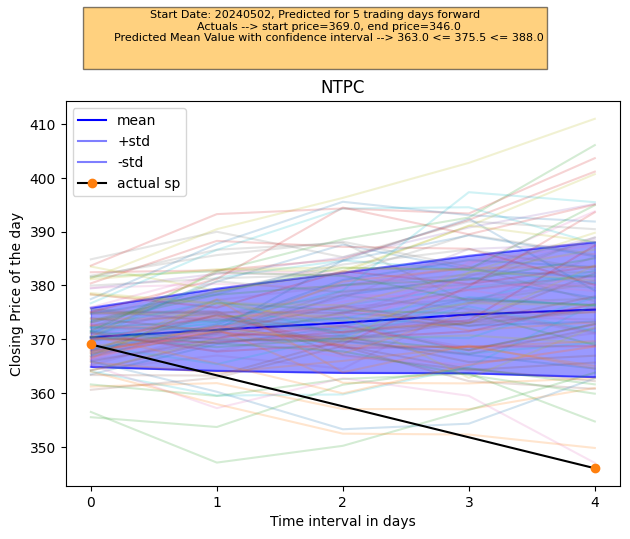

,dm,dm+std,dm-std
0,347.516783,352.531315,342.502251
1,349.015768,356.176927,341.854608
2,350.173298,358.794925,341.551670
3,351.369477,361.517908,341.221045
4,352.709939,364.337013,341.082865


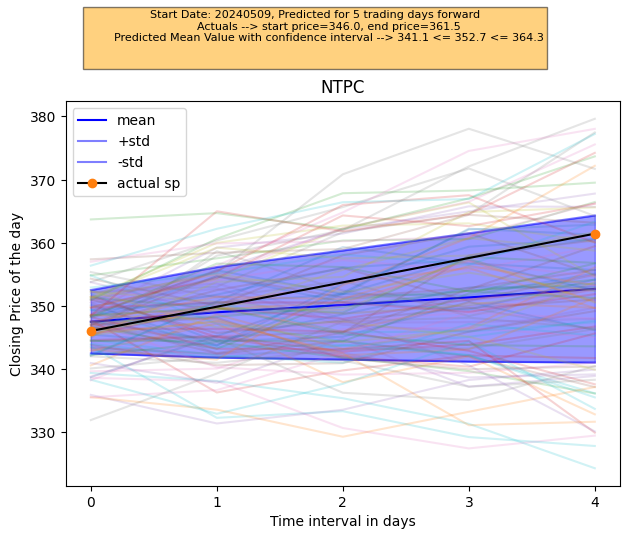

,dm,dm+std,dm-std
0,362.945905,368.133445,357.758364
1,364.642013,371.996977,357.287048
2,365.787597,374.732702,356.842491
3,366.912365,377.130735,356.693995
4,368.411246,380.004539,356.817953


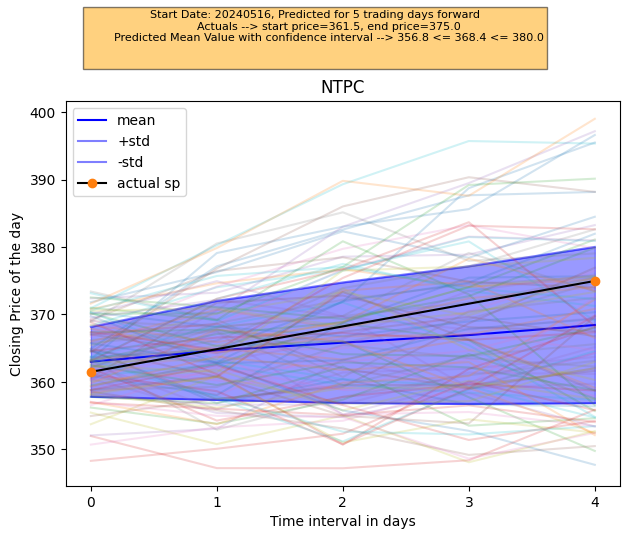

,dm,dm+std,dm-std
0,376.111221,381.734254,370.488187
1,377.829395,385.678963,369.979826
2,379.335156,388.915735,369.754578
3,380.613600,391.656129,369.571070
4,382.128154,394.623708,369.632599


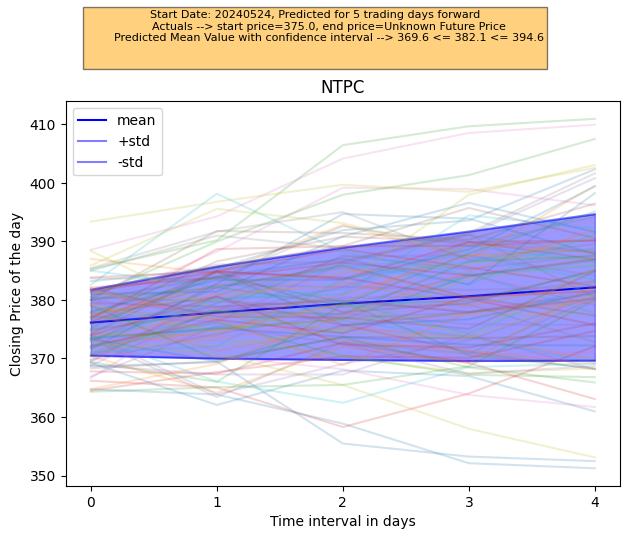

In [15]:
# for r in range(len(vol_df)):
#     cur_st = pd.DataFrame(vol_df.iloc[i]).T
#     display(cur_st)

#     for i in range(3, -1, -1):
#         sim_k_runs(cur_st, sp_cols, last_run=i)

In [66]:
%%time


CPU times: user 579 ms, sys: 4.33 ms, total: 583 ms
Wall time: 581 ms


In [69]:
stat_df = pd.DataFrame(daily_stats)
stat_df

,dm,dm+std,dm-std
0,362.776574,367.988737,357.564411
1,364.057720,371.245540,356.869901
2,365.722317,374.772628,356.672005
3,367.383824,378.017529,356.750119
4,368.910849,380.865260,356.956439


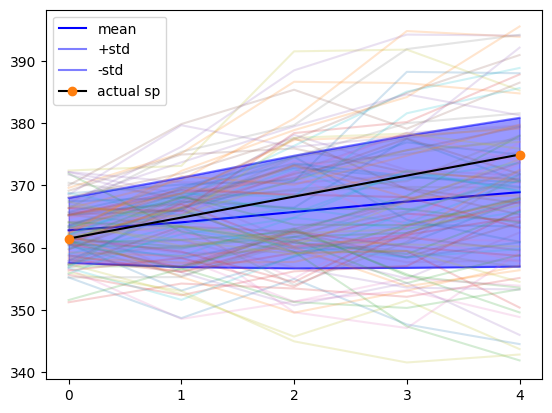

In [115]:
cur_st

,Symbol,Daily Drift,Annual Drift,Daily Volatility,Annual Volatility,Drift Mean,sp_20240524,sp_20240516,sp_20240509,sp_20240502
33,NTPC,0.003866,0.974218,0.014594,0.231669,0.003759,374.950012,361.450012,346.049988,369.049988


### Rough

In [79]:
get_volatility('ZYDUSLIFE.NS')

(0.020992579894727276, 0.33324687467461717)

In [10]:
ticker = yf.Ticker('ZYDUSLIFE.NS')

In [11]:
df = ticker.history(start='2024-01-01', period='45d')['Close'].reset_index()

In [12]:
df

,Date,Close
0,2024-01-01 00:00:00+05:30,699.150024
1,2024-01-02 00:00:00+05:30,712.250000
2,2024-01-03 00:00:00+05:30,710.400024
3,2024-01-04 00:00:00+05:30,709.150024
4,2024-01-05 00:00:00+05:30,714.250000
...,...,...
91,2024-05-17 00:00:00+05:30,1051.400024
92,2024-05-21 00:00:00+05:30,1088.349976
93,2024-05-22 00:00:00+05:30,1080.650024
94,2024-05-23 00:00:00+05:30,1086.050049


In [16]:
df['Close'].iloc[-1-5]

1009.0

In [9]:
df['Close'].iloc[-1]

1076.0

In [19]:
df['Date'].iloc[-1].strftime('%Y%m%d')

'20240524'

In [5]:
df['Prev Close'] = df['Close'].shift(1)

In [6]:
df['Daily Rt'] = np.log(df['Close'] / df['Prev Close'])

In [72]:
df.to_csv('../data/test/zyduslife.csv', index=False)

In [7]:
daily_volatility = df['Daily Rt'].std()
daily_volatility

0.020992579894727276

In [17]:
annual_volatility = daily_volatility * 252
annual_volatility

5.290130133471274

In [10]:
daily_drift = df['Daily Rt'].mean()
daily_drift

0.0023213346431457697

In [11]:
annual_drift = daily_drift * np.sqrt(252)
annual_drift

0.036850045053135445

In [47]:
drift_mean = daily_drift * (0.5 * (daily_volatility**2))
drift_mean

5.114926372216871e-07

In [75]:
df.shape

(46, 4)

In [41]:
print(scipy.stats.norm.ppf(0.001))
for i in np.arange(0.1, 1, 0.1):
    print(scipy.stats.norm.ppf(i))

scipy.stats.norm.ppf(0.99)

-3.090232306167813
-1.2815515655446004
-0.8416212335729142
-0.5244005127080407
-0.2533471031357997
0.0
0.2533471031357997
0.524400512708041
0.8416212335729143
1.2815515655446004


2.3263478740408408

In [52]:
z = scipy.stats.norm.ppf(np.random.rand())
z

-0.22154311410959399

In [53]:
log_return = drift_mean + daily_volatility * z
log_return

-0.004650250030435112

In [50]:
# df

In [55]:
1103 * np.exp(log_return)

1097.8826818426446

In [59]:
for t in range(5):
    print(gbm(1103, drift_mean, daily_volatility))

[1107.6775052973544, 1116.2217552350326, 1096.8689260428166, 1073.9912096456549, 1067.7138614775863]
[1137.8366507936128, 1123.0422409478956, 1113.93854936939, 1107.9055468796291, 1111.2749651439062]
[1115.6323054216477, 1080.4382072839521, 1119.3698838453004, 1081.2854003543848, 1113.4145764610294]
[1101.7925211188287, 1126.6740808010804, 1114.0982832161392, 1141.237050817523, 1154.2829107776654]
[1098.487855504138, 1129.1833658466135, 1128.5694668456322, 1141.6288328752357, 1139.8646827914936]
